In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [24]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess
import mydatasets as datasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## load model and get dataset

In [236]:
# name = '../exp/raftsup_0pretrain_0/'
name = '../exp/fullsup_0pretrain/'
trained_model = name + 'trained_model'

os.listdir(trained_model)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_120000.pth',
 'model_90000.pth',
 'model_50000.pth',
 'model_110000.pth',
 'model_160000.pth',
 'model_100000.pth',
 'model_40000.pth',
 'model_10000.pth',
 'model_170000.pth',
 'model_140000.pth',
 'model_30000.pth',
 'model_150000.pth',
 'model_70000.pth',
 'model_60000.pth',
 'model_20000.pth',
 'model_130000.pth',
 'model_80000.pth']

In [237]:
mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

tdw_dataset = datasets.TdwAffinityDataset(training=False, mean=mean, std=std, 
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True)

print(len(tdw_dataset))

500


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [238]:
ckpt_iter = 170000
load_path = os.path.join(trained_model, 'model_' + str(ckpt_iter) + '.pth')
use_pretrained = False

AFF_R = 5
model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R, pretrained_backbone=use_pretrained)
model = model.to(device)

did_load = model.load_state_dict(torch.load(load_path)) 
model.eval()
print(did_load)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


### check eval on single example

In [240]:
ex = 3
img, cats, _ = [x[None].cuda() for x in tdw_dataset[ex]]
outputs = model(torch.cat([img]*3, 0))
ins, ins_list = make_ins_seg(outputs, st_for=0,
                            en_for=5, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [241]:
outputs[1].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([3, 2, 32, 32])

[  0   2  44  66 132 138 147 153 185 217]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


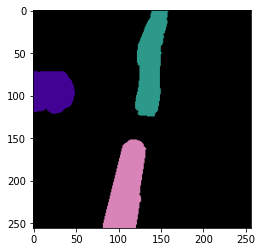

In [242]:
cls_ = 0
print(np.unique(ins[cls_]))
plt.imshow(ins[cls_])
plt.show()

In [199]:
import dorsalventral.models.segmentation.aggregate_pseudolabels as confidence
import dorsalventral.trainval.segmentation_metrics as metrics
from tqdm import tqdm

def segments_to_masks(segments, max_segments=16):
    masks = torch.from_numpy(segments).cuda().permute(2,0,1)
    masks = datasets.TdwAffinityDataset._object_id_hash(masks) # [1,H,W]
    unique = torch.unique(masks)[:max_segments]
    masks = (unique[:,None,None] == masks)
    return masks

def val_gt_moving_iou(model, dataset, ex=3, val_single=True):
    dataset.is_test = True
    if not isinstance(ex, list):
        ex = [ex]
    imgs, gts = [], []
    for e in ex:
        img, gt_full, gt_moving = dataset[e]
        imgs.append(img)
        gts.append(gt_moving if val_single else gt_full)
    imgs = torch.stack(imgs, 0).cuda()
    gts = torch.stack(gts, 0)    
    out = model(imgs)
    
    preds = []
    for i in range(len(ex)):
        _out = [v[i][None] for v in out]
        ins, _ = make_ins_seg(_out, st_for=0, en_for=5, min_size=5)
        pred = segments_to_masks(ins[0])
        pred = pred.long().argmax(0).to(torch.int32).cpu()
        preds.append(pred)

    preds = torch.stack(preds, 0)
    
    size = list(gts.shape[-2:])
    
    M = metrics.SegmentationMetrics(
        gt_objects=gts.to(torch.int32),
        pred_objects=preds,
        size=size
    )
    
    M.compute_matched_IoUs(exclude_gt_ids=[0])
    ious_per_obj = M.best_ious
    ious = M.mean_ious
    return (imgs, preds, gts, ious, ious_per_obj)

def val_objects(model, dataset, examples=range(4), print_every=10, val_single=True):
    if examples is None:
        examples = range(len(dataset))
    
    ious = []
    running_mean = 0.
    for i, ex in enumerate(tqdm(examples)):
        _, _, _, iou, _ = val_gt_moving_iou(model, dataset, ex=ex, val_single=val_single)
        ious.append(iou[0])
        if not np.isnan(iou[0]):
            running_mean += iou[0] / print_every
        if ((i + 1) % print_every) == 0:
            print("mean of last %d ---- %.3f" % (print_every, running_mean))
            print("mean of full %d ---- %.3f" % (i+1, np.nanmean(np.array(ious))))
            running_mean = 0.
        
    mean_iou = np.nanmean(np.array(ious))
    return mean_iou, ious

# pred, gt, ious, ious_per_obj = val_gt_moving_iou(model, tdw_dataset, ex=[2,3], val_single=False)
# print(ious)
mean_ious, ious = val_objects(model, tdw_dataset, examples=range(6), print_every=2, val_single=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
 33%|███▎      | 2/6 [00:07<00:13,  3.30s/it]

mean of last 2 ---- 0.154
mean of full 2 ---- 0.154


 67%|██████▋   | 4/6 [00:09<00:03,  1.76s/it]

mean of last 2 ---- 0.292
mean of full 4 ---- 0.223


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]

mean of last 2 ---- 0.165
mean of full 6 ---- 0.203


In [173]:
# raft-trained 60k
# mean_ious, ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
print(mean_ious)

0.1643385600419817


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [176]:
# # full-trained 70k
# full_mean_ious, full_ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=False)
# print(full_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/500 [01:00<36:03,  4.41s/it] 

mean of last 10 ---- 0.753
mean of full 10 ---- 0.753


  4%|▍         | 20/500 [01:46<38:19,  4.79s/it]

mean of last 10 ---- 0.759
mean of full 20 ---- 0.756


  6%|▌         | 30/500 [02:55<53:24,  6.82s/it]  

mean of last 10 ---- 0.731
mean of full 30 ---- 0.748


  8%|▊         | 40/500 [04:03<1:03:04,  8.23s/it]

mean of last 10 ---- 0.841
mean of full 40 ---- 0.771


 10%|█         | 50/500 [04:53<48:05,  6.41s/it]  

mean of last 10 ---- 0.846
mean of full 50 ---- 0.786


 12%|█▏        | 60/500 [06:11<1:08:10,  9.30s/it]

mean of last 10 ---- 0.775
mean of full 60 ---- 0.784


 14%|█▍        | 70/500 [07:01<33:31,  4.68s/it]  

mean of last 10 ---- 0.827
mean of full 70 ---- 0.790


 16%|█▌        | 80/500 [07:58<41:33,  5.94s/it]

mean of last 10 ---- 0.809
mean of full 80 ---- 0.793


 18%|█▊        | 90/500 [08:59<46:21,  6.78s/it]

mean of last 10 ---- 0.808
mean of full 90 ---- 0.794


 20%|██        | 100/500 [10:05<44:47,  6.72s/it]

mean of last 10 ---- 0.687
mean of full 100 ---- 0.784


 22%|██▏       | 110/500 [11:23<50:09,  7.72s/it]  

mean of last 10 ---- 0.749
mean of full 110 ---- 0.781


 24%|██▍       | 120/500 [12:35<1:07:39, 10.68s/it]

mean of last 10 ---- 0.829
mean of full 120 ---- 0.785


 26%|██▌       | 130/500 [14:04<50:06,  8.13s/it]  

mean of last 10 ---- 0.731
mean of full 130 ---- 0.780


 28%|██▊       | 140/500 [17:00<2:13:49, 22.30s/it]

mean of last 10 ---- 0.809
mean of full 140 ---- 0.782


 30%|███       | 150/500 [18:54<1:04:10, 11.00s/it]

mean of last 10 ---- 0.865
mean of full 150 ---- 0.788


 32%|███▏      | 160/500 [20:38<1:09:39, 12.29s/it]

mean of last 10 ---- 0.841
mean of full 160 ---- 0.791


 34%|███▍      | 170/500 [23:16<1:22:52, 15.07s/it]

mean of last 10 ---- 0.647
mean of full 170 ---- 0.783


 36%|███▌      | 180/500 [25:05<40:01,  7.50s/it]  

mean of last 10 ---- 0.643
mean of full 180 ---- 0.775


 38%|███▊      | 190/500 [26:51<40:26,  7.83s/it]  

mean of last 10 ---- 0.691
mean of full 190 ---- 0.771


 40%|████      | 200/500 [28:48<49:46,  9.95s/it]  

mean of last 10 ---- 0.736
mean of full 200 ---- 0.769


 42%|████▏     | 210/500 [31:24<1:23:59, 17.38s/it]

mean of last 10 ---- 0.673
mean of full 210 ---- 0.764


 44%|████▍     | 220/500 [34:13<1:02:35, 13.41s/it]

mean of last 10 ---- 0.719
mean of full 220 ---- 0.762


 46%|████▌     | 230/500 [35:53<48:20, 10.74s/it]  

mean of last 10 ---- 0.861
mean of full 230 ---- 0.767


 48%|████▊     | 240/500 [37:42<42:18,  9.76s/it]  

mean of last 10 ---- 0.813
mean of full 240 ---- 0.768


 50%|█████     | 250/500 [39:30<49:11, 11.80s/it]

mean of last 10 ---- 0.708
mean of full 250 ---- 0.766


 52%|█████▏    | 260/500 [41:00<35:07,  8.78s/it]

mean of last 10 ---- 0.781
mean of full 260 ---- 0.767


 54%|█████▍    | 270/500 [42:36<39:18, 10.25s/it]

mean of last 10 ---- 0.861
mean of full 270 ---- 0.770


 56%|█████▌    | 280/500 [45:26<1:02:39, 17.09s/it]

mean of last 10 ---- 0.785
mean of full 280 ---- 0.771


 58%|█████▊    | 290/500 [47:09<26:08,  7.47s/it]  

mean of last 10 ---- 0.727
mean of full 290 ---- 0.769


 60%|██████    | 300/500 [48:41<42:30, 12.75s/it]

mean of last 10 ---- 0.798
mean of full 300 ---- 0.770


 62%|██████▏   | 310/500 [49:48<19:59,  6.31s/it]

mean of last 10 ---- 0.888
mean of full 310 ---- 0.774


 64%|██████▍   | 320/500 [51:35<32:22, 10.79s/it]

mean of last 10 ---- 0.748
mean of full 320 ---- 0.773


 66%|██████▌   | 330/500 [53:19<38:10, 13.47s/it]

mean of last 10 ---- 0.797
mean of full 330 ---- 0.774


 68%|██████▊   | 340/500 [54:12<11:35,  4.35s/it]

mean of last 10 ---- 0.775
mean of full 340 ---- 0.774


 70%|███████   | 350/500 [55:59<22:41,  9.08s/it]

mean of last 10 ---- 0.852
mean of full 350 ---- 0.776


 72%|███████▏  | 360/500 [57:49<23:05,  9.90s/it]

mean of last 10 ---- 0.873
mean of full 360 ---- 0.779


 74%|███████▍  | 370/500 [59:11<17:19,  7.99s/it]

mean of last 10 ---- 0.793
mean of full 370 ---- 0.779


 76%|███████▌  | 380/500 [1:01:37<26:08, 13.07s/it]

mean of last 10 ---- 0.759
mean of full 380 ---- 0.779


 78%|███████▊  | 390/500 [1:03:56<25:21, 13.83s/it]

mean of last 10 ---- 0.758
mean of full 390 ---- 0.778


 80%|████████  | 400/500 [1:05:46<20:47, 12.48s/it]

mean of last 10 ---- 0.843
mean of full 400 ---- 0.780


 82%|████████▏ | 410/500 [1:07:51<20:11, 13.46s/it]

mean of last 10 ---- 0.775
mean of full 410 ---- 0.780


 84%|████████▍ | 420/500 [1:09:49<12:23,  9.30s/it]

mean of last 10 ---- 0.780
mean of full 420 ---- 0.780


 86%|████████▌ | 430/500 [1:11:26<14:48, 12.69s/it]

mean of last 10 ---- 0.771
mean of full 430 ---- 0.779


 88%|████████▊ | 440/500 [1:12:42<07:11,  7.18s/it]

mean of last 10 ---- 0.730
mean of full 440 ---- 0.778


 90%|█████████ | 450/500 [1:15:05<11:58, 14.37s/it]

mean of last 10 ---- 0.779
mean of full 450 ---- 0.778


 92%|█████████▏| 460/500 [1:16:40<06:43, 10.08s/it]

mean of last 10 ---- 0.826
mean of full 460 ---- 0.779


 94%|█████████▍| 470/500 [1:18:09<04:34,  9.16s/it]

mean of last 10 ---- 0.882
mean of full 470 ---- 0.782


 96%|█████████▌| 480/500 [1:20:04<02:39,  7.97s/it]

mean of last 10 ---- 0.821
mean of full 480 ---- 0.782


 98%|█████████▊| 490/500 [1:22:00<01:47, 10.73s/it]

mean of last 10 ---- 0.839
mean of full 490 ---- 0.783


100%|██████████| 500/500 [1:24:08<00:00, 10.10s/it]

mean of last 10 ---- 0.798
mean of full 500 ---- 0.784
0.7837950629542983


In [243]:
# # full-trained 170k
# full_mean_ious, full_ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=False)
# print(full_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/500 [00:58<35:00,  4.29s/it] 

mean of last 10 ---- 0.817
mean of full 10 ---- 0.817


  4%|▍         | 20/500 [01:40<36:46,  4.60s/it]

mean of last 10 ---- 0.834
mean of full 20 ---- 0.826


  6%|▌         | 30/500 [02:47<49:54,  6.37s/it]  

mean of last 10 ---- 0.830
mean of full 30 ---- 0.827


  8%|▊         | 40/500 [03:55<1:03:35,  8.29s/it]

mean of last 10 ---- 0.878
mean of full 40 ---- 0.840


 10%|█         | 50/500 [04:44<47:04,  6.28s/it]  

mean of last 10 ---- 0.837
mean of full 50 ---- 0.839


 12%|█▏        | 60/500 [06:01<1:08:00,  9.27s/it]

mean of last 10 ---- 0.735
mean of full 60 ---- 0.822


 14%|█▍        | 70/500 [06:51<33:05,  4.62s/it]  

mean of last 10 ---- 0.791
mean of full 70 ---- 0.818


 16%|█▌        | 80/500 [07:48<41:58,  6.00s/it]

mean of last 10 ---- 0.782
mean of full 80 ---- 0.813


 18%|█▊        | 90/500 [08:45<41:17,  6.04s/it]

mean of last 10 ---- 0.825
mean of full 90 ---- 0.814


 20%|██        | 100/500 [09:51<43:49,  6.57s/it]

mean of last 10 ---- 0.767
mean of full 100 ---- 0.810


 22%|██▏       | 110/500 [11:07<49:08,  7.56s/it]  

mean of last 10 ---- 0.788
mean of full 110 ---- 0.808


 24%|██▍       | 120/500 [12:15<59:45,  9.44s/it]

mean of last 10 ---- 0.837
mean of full 120 ---- 0.810


 26%|██▌       | 130/500 [13:43<48:20,  7.84s/it]  

mean of last 10 ---- 0.799
mean of full 130 ---- 0.809


 28%|██▊       | 140/500 [16:29<2:01:04, 20.18s/it]

mean of last 10 ---- 0.868
mean of full 140 ---- 0.813


 30%|███       | 150/500 [18:18<1:01:59, 10.63s/it]

mean of last 10 ---- 0.859
mean of full 150 ---- 0.817


 32%|███▏      | 160/500 [19:59<1:05:55, 11.63s/it]

mean of last 10 ---- 0.809
mean of full 160 ---- 0.816


 34%|███▍      | 170/500 [22:28<1:19:17, 14.42s/it]

mean of last 10 ---- 0.632
mean of full 170 ---- 0.805


 36%|███▌      | 180/500 [24:13<39:46,  7.46s/it]  

mean of last 10 ---- 0.783
mean of full 180 ---- 0.804


 38%|███▊      | 190/500 [25:58<39:34,  7.66s/it]  

mean of last 10 ---- 0.683
mean of full 190 ---- 0.798


 40%|████      | 200/500 [27:47<46:58,  9.39s/it]  

mean of last 10 ---- 0.775
mean of full 200 ---- 0.796


 42%|████▏     | 210/500 [30:12<1:18:01, 16.14s/it]

mean of last 10 ---- 0.755
mean of full 210 ---- 0.794


 44%|████▍     | 220/500 [32:46<57:53, 12.40s/it]  

mean of last 10 ---- 0.743
mean of full 220 ---- 0.792


 46%|████▌     | 230/500 [34:19<47:04, 10.46s/it]

mean of last 10 ---- 0.828
mean of full 230 ---- 0.794


 48%|████▊     | 240/500 [36:01<40:16,  9.29s/it]

mean of last 10 ---- 0.800
mean of full 240 ---- 0.794


 50%|█████     | 250/500 [37:44<47:43, 11.45s/it]

mean of last 10 ---- 0.804
mean of full 250 ---- 0.794


 52%|█████▏    | 260/500 [39:11<33:53,  8.47s/it]

mean of last 10 ---- 0.792
mean of full 260 ---- 0.794


 54%|█████▍    | 270/500 [40:46<38:39, 10.09s/it]

mean of last 10 ---- 0.884
mean of full 270 ---- 0.798


 56%|█████▌    | 280/500 [43:04<47:17, 12.90s/it]  

mean of last 10 ---- 0.808
mean of full 280 ---- 0.798


 58%|█████▊    | 290/500 [44:37<24:19,  6.95s/it]

mean of last 10 ---- 0.778
mean of full 290 ---- 0.797


 60%|██████    | 300/500 [45:58<36:39, 11.00s/it]

mean of last 10 ---- 0.798
mean of full 300 ---- 0.797


 62%|██████▏   | 310/500 [47:01<18:30,  5.84s/it]

mean of last 10 ---- 0.876
mean of full 310 ---- 0.800


 64%|██████▍   | 320/500 [48:47<32:21, 10.79s/it]

mean of last 10 ---- 0.829
mean of full 320 ---- 0.801


 66%|██████▌   | 330/500 [50:32<38:38, 13.64s/it]

mean of last 10 ---- 0.805
mean of full 330 ---- 0.801


 68%|██████▊   | 340/500 [51:25<11:40,  4.38s/it]

mean of last 10 ---- 0.767
mean of full 340 ---- 0.800


 70%|███████   | 350/500 [53:18<23:55,  9.57s/it]

mean of last 10 ---- 0.838
mean of full 350 ---- 0.801


 72%|███████▏  | 360/500 [55:11<24:11, 10.37s/it]

mean of last 10 ---- 0.918
mean of full 360 ---- 0.804


 74%|███████▍  | 370/500 [56:31<17:11,  7.93s/it]

mean of last 10 ---- 0.818
mean of full 370 ---- 0.805


 76%|███████▌  | 380/500 [58:50<24:53, 12.44s/it]

mean of last 10 ---- 0.745
mean of full 380 ---- 0.803


 78%|███████▊  | 390/500 [1:01:21<26:08, 14.26s/it]

mean of last 10 ---- 0.824
mean of full 390 ---- 0.804


 80%|████████  | 400/500 [1:03:12<21:10, 12.70s/it]

mean of last 10 ---- 0.889
mean of full 400 ---- 0.806


 82%|████████▏ | 410/500 [1:05:20<21:00, 14.00s/it]

mean of last 10 ---- 0.851
mean of full 410 ---- 0.807


 84%|████████▍ | 420/500 [1:07:16<12:08,  9.11s/it]

mean of last 10 ---- 0.794
mean of full 420 ---- 0.807


 86%|████████▌ | 430/500 [1:08:51<14:49, 12.71s/it]

mean of last 10 ---- 0.693
mean of full 430 ---- 0.804


 88%|████████▊ | 440/500 [1:10:09<07:15,  7.26s/it]

mean of last 10 ---- 0.712
mean of full 440 ---- 0.802


 90%|█████████ | 450/500 [1:12:32<12:04, 14.49s/it]

mean of last 10 ---- 0.821
mean of full 450 ---- 0.802


 92%|█████████▏| 460/500 [1:14:01<06:14,  9.36s/it]

mean of last 10 ---- 0.808
mean of full 460 ---- 0.802


 94%|█████████▍| 470/500 [1:15:27<04:19,  8.66s/it]

mean of last 10 ---- 0.868
mean of full 470 ---- 0.804


 96%|█████████▌| 480/500 [1:17:28<03:10,  9.53s/it]

mean of last 10 ---- 0.650
mean of full 480 ---- 0.801


 98%|█████████▊| 490/500 [1:19:19<01:43, 10.37s/it]

mean of last 10 ---- 0.840
mean of full 490 ---- 0.801


100%|██████████| 500/500 [1:21:23<00:00,  9.77s/it]

mean of last 10 ---- 0.816
mean of full 500 ---- 0.802
0.8016193775978283


In [188]:
# # raft-trained 70k - trainval, moving object only
# raft_trainval_mean_ious, _ = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=True)
# print(raft_trainval_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/490 [00:18<12:22,  1.55s/it]

mean of last 10 ---- 0.849
mean of full 10 ---- 0.849


  4%|▍         | 20/490 [00:28<07:26,  1.05it/s]

mean of last 10 ---- 0.803
mean of full 20 ---- 0.826


  5%|▌         | 25/490 [00:36<10:23,  1.34s/it]/home/dbear/DorsalVentral/dorsalventral/trainval/segmentation_metrics.py:380: RuntimeWarning: Mean of empty slice
  self._mean_ious = np.array([np.nanmean(self.best_ious[b]) for b in range(self.BT)])
  6%|▌         | 30/490 [00:41<09:31,  1.24s/it]

mean of last 10 ---- nan
mean of full 30 ---- 0.773


  8%|▊         | 40/490 [00:50<08:02,  1.07s/it]

mean of last 10 ---- nan
mean of full 40 ---- 0.764


 10%|█         | 50/490 [01:10<14:14,  1.94s/it]

mean of last 10 ---- nan
mean of full 50 ---- 0.770


 12%|█▏        | 60/490 [01:20<08:36,  1.20s/it]

mean of last 10 ---- 0.730
mean of full 60 ---- 0.763


 14%|█▍        | 70/490 [01:36<12:26,  1.78s/it]

mean of last 10 ---- 0.670
mean of full 70 ---- 0.749


 16%|█▋        | 80/490 [02:08<17:36,  2.58s/it]

mean of last 10 ---- nan
mean of full 80 ---- 0.747


 18%|█▊        | 90/490 [02:19<05:35,  1.19it/s]

mean of last 10 ---- nan
mean of full 90 ---- 0.729


 20%|██        | 100/490 [02:32<10:43,  1.65s/it]

mean of last 10 ---- 0.732
mean of full 100 ---- 0.729


 22%|██▏       | 110/490 [03:13<1:02:27,  9.86s/it]

mean of last 10 ---- 0.745
mean of full 110 ---- 0.731


 24%|██▍       | 120/490 [03:25<08:05,  1.31s/it]  

mean of last 10 ---- nan
mean of full 120 ---- 0.732


 27%|██▋       | 130/490 [03:37<07:09,  1.19s/it]

mean of last 10 ---- nan
mean of full 130 ---- 0.723


 29%|██▊       | 140/490 [03:51<06:26,  1.11s/it]

mean of last 10 ---- 0.847
mean of full 140 ---- 0.732


 31%|███       | 150/490 [04:00<07:05,  1.25s/it]

mean of last 10 ---- nan
mean of full 150 ---- 0.726


 33%|███▎      | 160/490 [04:18<08:56,  1.63s/it]

mean of last 10 ---- nan
mean of full 160 ---- 0.729


 35%|███▍      | 171/490 [04:44<07:16,  1.37s/it]

mean of last 10 ---- 0.736
mean of full 170 ---- 0.730


 37%|███▋      | 180/490 [04:57<09:39,  1.87s/it]

mean of last 10 ---- 0.608
mean of full 180 ---- 0.723


 39%|███▉      | 191/490 [05:10<06:52,  1.38s/it]

mean of last 10 ---- 0.716
mean of full 190 ---- 0.722


 41%|████      | 200/490 [05:31<07:43,  1.60s/it]

mean of last 10 ---- nan
mean of full 200 ---- 0.718


 43%|████▎     | 211/490 [05:45<04:19,  1.07it/s]

mean of last 10 ---- 0.811
mean of full 210 ---- 0.723


 45%|████▍     | 220/490 [06:06<04:43,  1.05s/it]

mean of last 10 ---- 0.717
mean of full 220 ---- 0.723


 47%|████▋     | 230/490 [06:26<09:02,  2.09s/it]

mean of last 10 ---- nan
mean of full 230 ---- 0.724


 49%|████▉     | 240/490 [06:41<04:04,  1.02it/s]

mean of last 10 ---- 0.830
mean of full 240 ---- 0.729


 51%|█████     | 250/490 [07:10<09:29,  2.37s/it]

mean of last 10 ---- nan
mean of full 250 ---- 0.725


 53%|█████▎    | 260/490 [07:27<05:37,  1.47s/it]

mean of last 10 ---- nan
mean of full 260 ---- 0.725


 55%|█████▌    | 270/490 [07:50<05:27,  1.49s/it]

mean of last 10 ---- 0.800
mean of full 270 ---- 0.728


 57%|█████▋    | 281/490 [08:02<03:54,  1.12s/it]

mean of last 10 ---- nan
mean of full 280 ---- 0.728


 59%|█████▉    | 290/490 [08:42<07:02,  2.11s/it]

mean of last 10 ---- 0.607
mean of full 290 ---- 0.724


 61%|██████    | 300/490 [09:02<06:47,  2.15s/it]

mean of last 10 ---- 0.626
mean of full 300 ---- 0.720


 63%|██████▎   | 310/490 [09:15<03:41,  1.23s/it]

mean of last 10 ---- 0.753
mean of full 310 ---- 0.721


 65%|██████▌   | 320/490 [09:25<03:24,  1.20s/it]

mean of last 10 ---- 0.899
mean of full 320 ---- 0.727


 68%|██████▊   | 331/490 [09:38<02:14,  1.18it/s]

mean of last 10 ---- 0.820
mean of full 330 ---- 0.730


 69%|██████▉   | 340/490 [09:49<02:42,  1.08s/it]

mean of last 10 ---- 0.695
mean of full 340 ---- 0.729


 71%|███████▏  | 350/490 [10:06<03:05,  1.33s/it]

mean of last 10 ---- 0.776
mean of full 350 ---- 0.730


 73%|███████▎  | 360/490 [10:20<02:03,  1.05it/s]

mean of last 10 ---- nan
mean of full 360 ---- 0.733


 76%|███████▌  | 371/490 [10:39<02:01,  1.02s/it]

mean of last 10 ---- nan
mean of full 370 ---- 0.734


 78%|███████▊  | 380/490 [11:08<04:08,  2.26s/it]

mean of last 10 ---- nan
mean of full 380 ---- 0.735


 80%|███████▉  | 391/490 [11:22<01:24,  1.18it/s]

mean of last 10 ---- 0.664
mean of full 390 ---- 0.733


 82%|████████▏ | 400/490 [11:35<02:54,  1.94s/it]

mean of last 10 ---- 0.686
mean of full 400 ---- 0.732


 84%|████████▎ | 410/490 [12:02<05:30,  4.13s/it]

mean of last 10 ---- 0.862
mean of full 410 ---- 0.735


 86%|████████▌ | 420/490 [12:26<01:42,  1.46s/it]

mean of last 10 ---- 0.795
mean of full 420 ---- 0.736


 88%|████████▊ | 430/490 [12:40<01:11,  1.20s/it]

mean of last 10 ---- 0.736
mean of full 430 ---- 0.736


 90%|████████▉ | 440/490 [12:52<00:50,  1.01s/it]

mean of last 10 ---- nan
mean of full 440 ---- 0.737


 92%|█████████▏| 450/490 [13:06<00:39,  1.02it/s]

mean of last 10 ---- 0.819
mean of full 450 ---- 0.739


 94%|█████████▍| 460/490 [13:20<00:26,  1.14it/s]

mean of last 10 ---- nan
mean of full 460 ---- 0.737


 96%|█████████▌| 470/490 [14:00<01:08,  3.40s/it]

mean of last 10 ---- nan
mean of full 470 ---- 0.740


 98%|█████████▊| 481/490 [14:11<00:06,  1.29it/s]

mean of last 10 ---- nan
mean of full 480 ---- 0.743


100%|██████████| 490/490 [14:31<00:00,  1.78s/it]

mean of last 10 ---- 0.672
mean of full 490 ---- 0.741
0.7412400684742754


In [201]:
# # raft-trained 70k - val, moving object only
# raft_val_mean_ious, all_ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=True)
# print(raft_val_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/500 [00:11<03:11,  2.56it/s] 

mean of last 10 ---- 0.207
mean of full 10 ---- 0.230


  4%|▍         | 21/500 [00:16<03:17,  2.42it/s]

mean of last 10 ---- 0.384
mean of full 20 ---- 0.328


  6%|▌         | 30/500 [00:26<08:19,  1.06s/it]

mean of last 10 ---- 0.371
mean of full 30 ---- 0.344


  8%|▊         | 40/500 [00:38<04:14,  1.81it/s]

mean of last 10 ---- 0.255
mean of full 40 ---- 0.320


 10%|█         | 50/500 [00:43<03:19,  2.25it/s]

mean of last 10 ---- 0.338
mean of full 50 ---- 0.324


 12%|█▏        | 61/500 [00:57<04:34,  1.60it/s]

mean of last 10 ---- 0.441
mean of full 60 ---- 0.350


 14%|█▍        | 70/500 [01:07<04:47,  1.49it/s]

mean of last 10 ---- 0.176
mean of full 70 ---- 0.329


 16%|█▌        | 81/500 [01:14<04:41,  1.49it/s]

mean of last 10 ---- 0.305
mean of full 80 ---- 0.326


 18%|█▊        | 90/500 [01:19<02:55,  2.34it/s]

mean of last 10 ---- 0.266
mean of full 90 ---- 0.323


 20%|██        | 100/500 [01:28<02:41,  2.47it/s]

mean of last 10 ---- 0.273
mean of full 100 ---- 0.321


 22%|██▏       | 110/500 [01:41<08:58,  1.38s/it]

mean of last 10 ---- 0.294
mean of full 110 ---- 0.321


 24%|██▍       | 120/500 [01:46<03:21,  1.88it/s]

mean of last 10 ---- 0.150
mean of full 120 ---- 0.309


 26%|██▌       | 130/500 [01:59<08:08,  1.32s/it]

mean of last 10 ---- 0.386
mean of full 130 ---- 0.315


 28%|██▊       | 140/500 [02:25<21:58,  3.66s/it]

mean of last 10 ---- 0.441
mean of full 140 ---- 0.325


 30%|███       | 150/500 [02:42<08:20,  1.43s/it]

mean of last 10 ---- 0.390
mean of full 150 ---- 0.329


 32%|███▏      | 160/500 [02:48<02:22,  2.39it/s]

mean of last 10 ---- 0.085
mean of full 160 ---- 0.318


 34%|███▍      | 170/500 [03:10<08:29,  1.54s/it]

mean of last 10 ---- 0.347
mean of full 170 ---- 0.319


 36%|███▌      | 180/500 [03:18<04:06,  1.30it/s]

mean of last 10 ---- 0.246
mean of full 180 ---- 0.315


 38%|███▊      | 191/500 [03:33<05:26,  1.06s/it]

mean of last 10 ---- 0.432
mean of full 190 ---- 0.322


 40%|████      | 200/500 [03:41<04:19,  1.16it/s]

mean of last 10 ---- 0.286
mean of full 200 ---- 0.320


 42%|████▏     | 210/500 [04:07<17:52,  3.70s/it]

mean of last 10 ---- 0.249
mean of full 210 ---- 0.316


 44%|████▍     | 220/500 [04:24<04:30,  1.03it/s]

mean of last 10 ---- 0.185
mean of full 220 ---- 0.310


 46%|████▌     | 230/500 [04:41<05:44,  1.28s/it]

mean of last 10 ---- 0.339
mean of full 230 ---- 0.311


 48%|████▊     | 240/500 [04:50<02:31,  1.72it/s]

mean of last 10 ---- 0.286
mean of full 240 ---- 0.311


 50%|█████     | 250/500 [04:56<01:56,  2.15it/s]

mean of last 10 ---- 0.301
mean of full 250 ---- 0.311


 52%|█████▏    | 260/500 [05:09<03:02,  1.32it/s]

mean of last 10 ---- 0.418
mean of full 260 ---- 0.315


 54%|█████▍    | 270/500 [05:28<06:02,  1.57s/it]

mean of last 10 ---- 0.306
mean of full 270 ---- 0.316


 56%|█████▌    | 280/500 [05:43<04:09,  1.13s/it]

mean of last 10 ---- 0.382
mean of full 280 ---- 0.320


 58%|█████▊    | 290/500 [05:55<05:10,  1.48s/it]

mean of last 10 ---- 0.458
mean of full 290 ---- 0.326


 60%|██████    | 301/500 [06:09<03:50,  1.16s/it]

mean of last 10 ---- 0.534
mean of full 300 ---- 0.336


 62%|██████▏   | 310/500 [06:15<01:45,  1.81it/s]

mean of last 10 ---- 0.197
mean of full 310 ---- 0.331


 64%|██████▍   | 321/500 [06:36<04:11,  1.41s/it]

mean of last 10 ---- 0.217
mean of full 320 ---- 0.329


 66%|██████▌   | 330/500 [06:52<04:35,  1.62s/it]

mean of last 10 ---- 0.340
mean of full 330 ---- 0.330


 68%|██████▊   | 340/500 [07:00<02:03,  1.29it/s]

mean of last 10 ---- 0.480
mean of full 340 ---- 0.334


 70%|███████   | 350/500 [07:17<05:42,  2.28s/it]

mean of last 10 ---- 0.495
mean of full 350 ---- 0.339


 72%|███████▏  | 360/500 [07:32<02:56,  1.26s/it]

mean of last 10 ---- 0.270
mean of full 360 ---- 0.340


 74%|███████▍  | 370/500 [07:52<05:44,  2.65s/it]

mean of last 10 ---- 0.417
mean of full 370 ---- 0.342


 76%|███████▌  | 380/500 [08:06<02:57,  1.48s/it]

mean of last 10 ---- 0.461
mean of full 380 ---- 0.346


 78%|███████▊  | 390/500 [08:28<05:06,  2.79s/it]

mean of last 10 ---- 0.292
mean of full 390 ---- 0.344


 80%|████████  | 400/500 [08:44<01:29,  1.12it/s]

mean of last 10 ---- 0.314
mean of full 400 ---- 0.343


 82%|████████▏ | 411/500 [09:17<04:23,  2.96s/it]

mean of last 10 ---- 0.515
mean of full 410 ---- 0.348


 84%|████████▍ | 420/500 [09:28<01:47,  1.34s/it]

mean of last 10 ---- 0.297
mean of full 420 ---- 0.346


 86%|████████▌ | 430/500 [09:52<05:26,  4.66s/it]

mean of last 10 ---- 0.366
mean of full 430 ---- 0.347


 88%|████████▊ | 440/500 [10:03<01:43,  1.72s/it]

mean of last 10 ---- 0.444
mean of full 440 ---- 0.349


 90%|█████████ | 451/500 [10:28<01:19,  1.62s/it]

mean of last 10 ---- 0.372
mean of full 450 ---- 0.351


 92%|█████████▏| 460/500 [10:46<01:15,  1.90s/it]

mean of last 10 ---- 0.536
mean of full 460 ---- 0.356


 94%|█████████▍| 470/500 [10:57<00:41,  1.38s/it]

mean of last 10 ---- 0.428
mean of full 470 ---- 0.358


 96%|█████████▌| 480/500 [11:26<00:26,  1.33s/it]

mean of last 10 ---- 0.235
mean of full 480 ---- 0.355


 98%|█████████▊| 490/500 [11:57<00:36,  3.66s/it]

mean of last 10 ---- 0.593
mean of full 490 ---- 0.360


100%|██████████| 500/500 [12:07<00:00,  1.45s/it]

mean of last 10 ---- 0.212
mean of full 500 ---- 0.357
0.3573458704162583


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


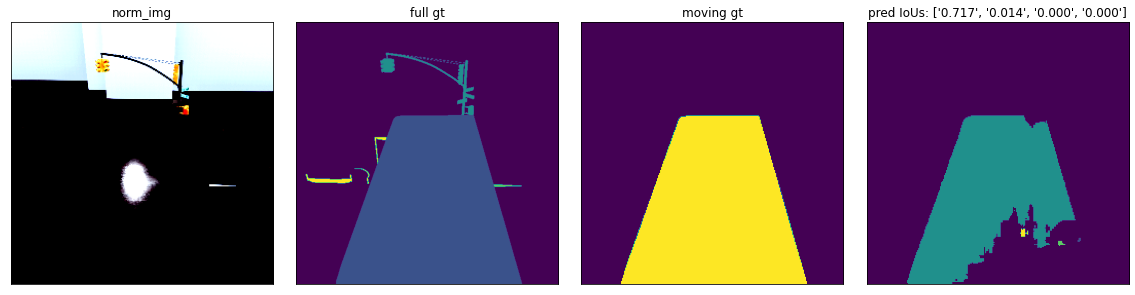

In [230]:
ex = 0
img, pred, gt, ious, ious_per_obj = val_gt_moving_iou(model, tdw_dataset, ex=ex, val_single=False)
_, _, gt_moving = tdw_dataset[ex]
fig, axes = plt.subplots(1,4,figsize=(16,4))

axes[0].imshow(tensor_to_arr(img))
axes[1].imshow(tensor_to_arr(gt))
axes[2].imshow(tensor_to_arr(gt_moving[None,::2,::2]))
axes[3].imshow(tensor_to_arr(pred))

titles = ['norm_img', 'full gt', 'moving gt', "pred IoUs: %s" % ["%.3f" % v for v in list(ious_per_obj[0])]]
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=12)    

# viz(pred[ex][None])
# plt.title("IOUs: %s" % ["%.3f" % v for v in list(ious_per_obj[0])])
# plt.show()
# viz(gt[ex][None])
plt.tight_layout()
plt.show()

In [231]:
out = model(img.cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


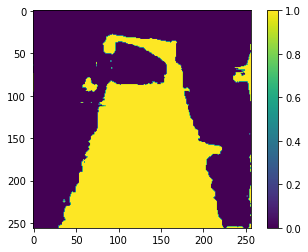

In [235]:
viz(out[4][:,0:1] > 0.15)
plt.colorbar()

In [228]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
import graph_partition
ins, ins_list = graph_partition.make_ins_seg(out, thresh=0.1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: make_ins_seg() got an unexpected keyword argument 'thresh'